# Imports

In [30]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLinear, BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

In [31]:
def roll(ix, ts, lags, preds):
    X = np.stack([np.roll(ts, i, axis=0) for i in range(lags, 0, -1)], axis=1)[lags:-preds,]
    Y = np.stack([np.roll(ts, -i, axis=0) for i in range(0, preds, 1)], axis=1)[lags:-preds,]
    Y_ix = ix[lags:-preds]
    return X, Y, Y_ix

def load_data(line, freq, lags, preds):
    train = pd.read_csv(f'Data/{line}_{freq}_train_raw.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    train_counts = pd.read_csv(f'Data/{line}_{freq}_train_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_train, Y_train, Y_train_ix = roll(train.index, train.values, lags, preds)
    
    val = pd.read_csv(f'Data/{line}_{freq}_val_raw.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    val_counts = pd.read_csv(f'Data/{line}_{freq}_val_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_val, Y_val, Y_val_ix = roll(val.index, val.values, lags, preds)

    test = pd.read_csv(f'Data/{line}_{freq}_test_raw.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    test_counts = pd.read_csv(f'Data/{line}_{freq}_test_sample_count.csv.gz', index_col=0, compression='gzip', parse_dates=True)
    X_test, Y_test, Y_test_ix = roll(test.index, test.values, lags, preds)
    
    # Descale
    df_mean = train.groupby([ train.index.weekday, train.index.hour]).mean()
    df_mean.index.names = ['DoW', 'ToD']
    
    X_train_mu, y_train_mu, _ = roll(train.index, df_mean.loc[zip(train.index.weekday, train.index.hour)].values, lags, preds)
    X_val_mu, y_val_mu, _ = roll(val.index, df_mean.loc[zip(val.index.weekday, val.index.hour)].values, lags, preds)
    X_test_mu, y_test_mu, _ = roll(test.index, df_mean.loc[zip(test.index.weekday, test.index.hour)].values, lags, preds)
    
    std = train.values.std(axis=0)
    
    return (X_train, Y_train, Y_train_ix, X_train_mu, y_train_mu, std, std), (X_val, Y_val, Y_val_ix, X_val_mu, y_val_mu, std, std), (X_test, Y_test, Y_test_ix, X_test_mu, y_test_mu, std, std)

# Data Preprocessing

In [32]:
line = '200S'
freq = '15min'
lags = 32
preds = 3

data_train, data_val, data_test = load_data(line, freq, lags, preds)

# Unpack tensors
(X_train, y_train, y_ix_train, X_train_mu, y_train_mu, X_train_std, y_train_std) = data_train
(X_val, y_val, y_ix_val, X_val_mu, y_val_mu, X_val_std, y_val_std) = data_val
(X_test, y_test, y_ix_test, X_test_mu, y_test_mu, X_test_std, y_test_std) = data_test

X_train = X_train
y_train = y_train
X_val = X_val
y_val = y_val
X_test = X_test
y_test = y_test

print('X_train', X_train.shape, 'y_train', y_train.shape)
print('X_val', X_val.shape, 'y_val', y_val.shape)
print('X_test', X_test.shape, 'y_test', y_test.shape)

X_train (8701, 32, 29) y_train (8701, 3, 29)
X_val (1309, 32, 29) y_val (1309, 3, 29)
X_test (1309, 32, 29) y_test (1309, 3, 29)


### Mean center and standardize data

In [33]:
X_train_scaled = (X_train - X_train_mu) / X_train_std
y_train_scaled = (y_train - y_train_mu) / y_train_std
X_val_scaled = (X_val - X_val_mu) / X_val_std
y_val_scaled = (y_val - y_val_mu) / y_val_std
X_test_scaled = (X_test - X_test_mu) / X_test_std
y_test_scaled = (y_test - y_test_mu) / y_test_std

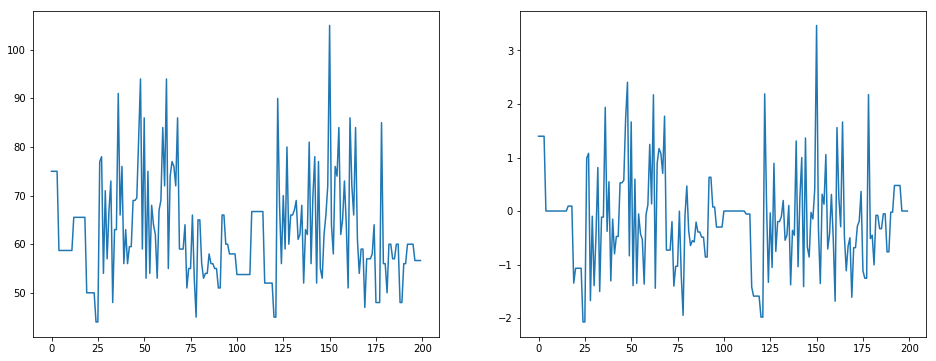

In [34]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
ln = 10
ax[0].plot(X_train[:200,0,ln])
ax[1].plot(X_train_scaled[:200,0,ln])

In [35]:
X_train_, y_train_ = torch.tensor(X_train_scaled).float().cuda(), torch.tensor(y_train_scaled).float().cuda()
X_val_, y_val_  = torch.tensor(X_val_scaled).float().cuda(), torch.tensor(y_val_scaled).float().cuda()
X_test_, y_test_  = torch.tensor(X_test_scaled).float().cuda(), torch.tensor(y_test_scaled).float().cuda()

ds_train = torch.utils.data.TensorDataset(X_train_, y_train_)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=50, shuffle=True)

# Training

In [69]:
@variational_estimator
class BRNN(nn.Module):
    
    def __init__(self, n_links, rnn_hidden_state, preds):
        super(BRNN, self).__init__()
        self.n_links = n_links
        self.rnn_hidden_state = rnn_hidden_state
        self.preds = preds
        
        self.lstm_1 = BayesianLSTM(n_links, rnn_hidden_state, prior_pi=1, prior_sigma_1 = 1.0, prior_sigma_2 = 0.01, posterior_rho_init=1.0, peephole=False)
        self.lstm_2 = BayesianLSTM(rnn_hidden_state, rnn_hidden_state, prior_pi=1, prior_sigma_1 = 1.0, prior_sigma_2 = 0.01, posterior_rho_init=1.0, peephole=False)
        self.linear = BayesianLinear(rnn_hidden_state, n_links, prior_pi=1, prior_sigma_1 = 4.0, prior_sigma_2 = 0.01, posterior_rho_init=3.0)
            
    def forward(self, x):
        # encoder
        x_, (c_t, h_t) = self.lstm_1(x)        
        # gathering only the latent end-of-sequence for the decoder layer
        x_ = x_[:, -3:, :]
        # decoder
        x_, _ = self.lstm_2(x_, hidden_states = (c_t, h_t)) 

        # time invariant dense layer
        x_ = x_.reshape(-1, self.rnn_hidden_state)
        x_ = self.linear(x_)
        x_ = x_.reshape(-1, self.preds, self.n_links)
        return x_

net = BRNN(X_train.shape[2], 15, preds).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,15], gamma=0.1)

In [70]:
losses = []
val_losses = []
for epoch in range(20):
    running_loss = 0
    
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=datapoints.shape[0]/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    preds_val = net(X_val_)
    loss_val = criterion(preds_val, y_val_)
    print(f"Epoch: {epoch}, Train-loss {running_loss:.4f} Val-loss: {loss_val:.4f}")
    scheduler.step()
    losses.append(running_loss)
    val_losses.append(loss_val)

Epoch: 0, Train-loss 890.0303 Val-loss: 1.1468
Epoch: 1, Train-loss 629.3809 Val-loss: 1.3135
Epoch: 2, Train-loss 683.2072 Val-loss: 1.1646
Epoch: 3, Train-loss 667.9868 Val-loss: 1.2968
Epoch: 4, Train-loss 672.2904 Val-loss: 1.5532
Epoch: 5, Train-loss 539.4569 Val-loss: 1.3129
Epoch: 6, Train-loss 430.5656 Val-loss: 1.3329
Epoch: 7, Train-loss 415.4368 Val-loss: 1.2920
Epoch: 8, Train-loss 406.0562 Val-loss: 1.2134
Epoch: 9, Train-loss 404.0539 Val-loss: 1.1046
Epoch: 10, Train-loss 401.8066 Val-loss: 1.2263
Epoch: 11, Train-loss 403.9026 Val-loss: 1.1847
Epoch: 12, Train-loss 401.4856 Val-loss: 1.3856
Epoch: 13, Train-loss 400.5464 Val-loss: 1.1432
Epoch: 14, Train-loss 403.0981 Val-loss: 1.1522
Epoch: 15, Train-loss 398.5151 Val-loss: 1.1216
Epoch: 16, Train-loss 392.5084 Val-loss: 1.0577
Epoch: 17, Train-loss 390.4639 Val-loss: 1.2987
Epoch: 18, Train-loss 388.1438 Val-loss: 1.2678
Epoch: 19, Train-loss 385.0183 Val-loss: 1.1419


# Prediction

In [66]:
S = 500
y_pred_s_ = np.empty((S,) + y_test.shape)
for s in range(S):
    y_pred_s_[s, ...] = net(X_test_).detach().cpu().numpy()
y_pred_s = y_pred_s_ * y_test_std + y_test_mu
np.save('BRNN/y_test_pred_samples_200s.npy', y_pred_s)

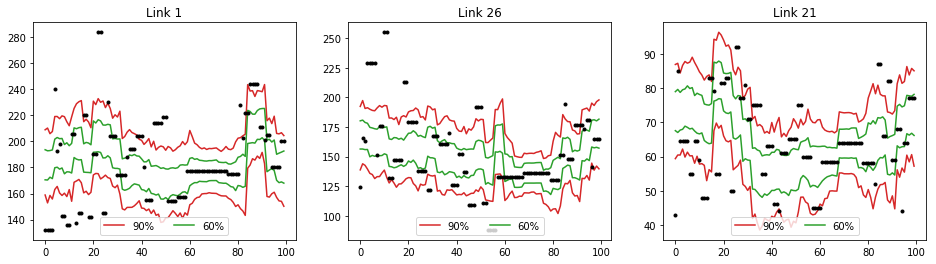

In [55]:
t = 200
ln = 4
n = 100

def plot_quantiles(ax, t, ln):
    ax.plot(np.quantile(y_pred_s[:, t:t+n, 0, ln], .95, axis=0), color='C3', label='90%')
    ax.plot(np.quantile(y_pred_s[:, t:t+n, 0, ln], .05, axis=0), color='C3')

    ax.plot(np.quantile(y_pred_s[:, t:t+n, 0, ln], .80, axis=0), color='C2', label='60%')
    ax.plot(np.quantile(y_pred_s[:, t:t+n, 0, ln], .20, axis=0), color='C2')
    
    #ax.plot(np.quantile(y_pred_s[t:t+n, 0, ln], .5, axis=1), color='K')
    ax.plot(y_test[t:t+n, 0, ln], color='K', linestyle='', marker='.')
    ax.set_title(f'Link {ln+1}')
    ax.legend(loc = 'lower center', ncol=2)

fig, ax = plt.subplots(figsize=(16, 4), ncols=3)
plot_quantiles(ax[0], t, 0)
plot_quantiles(ax[1], t, 25)
plot_quantiles(ax[2], t, 20)

#plt.savefig('dqr-quantiles.pdf', bbox_inches='tight')
#plt.savefig('dqr-quantiles.png', bbox_inches='tight', dpi=300)

In [56]:
y_pred_s_all = np.sum(y_pred_s, axis=3)
eval_quantiles = [0.025, 0.975, 0.05, 0.95, 0.10, 0.90, 0.20, 0.8, 0.4, 0.6]
pred_ints = [0.95,         0.90,       0.80,       0.60,      0.20]
y_pred_q = np.empty((len(eval_quantiles), len(y_test), preds))

for q, quan in enumerate(eval_quantiles):
    y_pred_q[q] = np.quantile(y_pred_s_all, quan, axis=0)

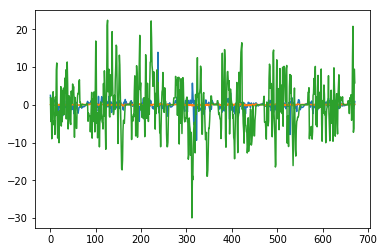

In [57]:
plt.plot(y_pred_s_[6,:,0,:].sum(axis=1)[:4*24*7])
plt.plot(y_pred_s_.mean(axis=0)[:,0,:].sum(axis=1)[:4*24*7])
plt.plot(y_test_scaled[:,0,:].sum(axis=1)[:4*24*7])

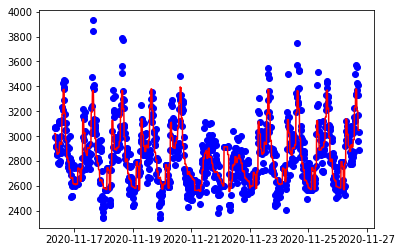

In [60]:
# Predict using mean of each weight
y_pred_mean_ = y_pred_s_.mean(axis=0)
y_pred_mean = y_pred_mean_ * y_test_std + y_test_mu
up_to = 1000
plt.plot(y_ix_test[:up_to], np.sum(y_test[:up_to,0,:], axis=1), 'bo')
plt.plot(y_ix_test[:up_to], np.sum(y_pred_mean[:up_to,0,:], axis=1), 'r')

(1309, 3)

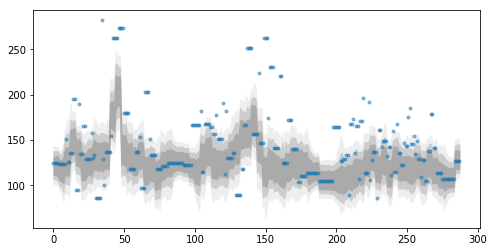

In [63]:
fig, ax = plt.subplots(figsize=(8, 4), ncols=1, sharey=True)

ln = 2
n = 4*24*3
o = 4*24*3 - 16
ax.fill_between(np.arange(n), np.quantile(y_pred_s[:, o:o+n, 0, ln], .05, axis=0),np.quantile(y_pred_s[:, o:o+n, 0, ln], .95, axis=0), color='#eeeeee')
ax.fill_between(np.arange(n), np.quantile(y_pred_s[:, o:o+n, 0, ln], .1, axis=0),np.quantile(y_pred_s[:, o:o+n, 0, ln], .9, axis=0), color='#cccccc')
ax.fill_between(np.arange(n), np.quantile(y_pred_s[:, o:o+n, 0, ln], .20, axis=0),np.quantile(y_pred_s[:, o:o+n, 0, ln], .80, axis=0), color='#aaaaaa')
plt.plot(y_test[o:o+n,0,ln], marker='.', linestyle='', alpha=.5, )
#plt.plot(y_test_pred[o:o+n,0,ln,0,0]*y_test_std[o:o+n,0,ln]+y_test_mean[o:o+n,0,ln], marker='', linestyle='-', alpha=1)
#plt.savefig('plot3.png', bbox_inches='tight', dpi=300)

In [64]:
y_test_sum = np.sum(y_test, axis=2)
y_pred_mean_sum = np.sum(y_pred_mean, axis=2)
for q in range(int(len(eval_quantiles)/2)):
    print(f"{int(np.round(pred_ints[q]*100,0))}\\% ", end='')
    for p in range(preds):
        q1 = y_pred_q[2*q, :, p]
        q2 = y_pred_q[2*q+1, :, p]
        icp=np.mean(np.logical_and(y_test_sum[:,p] > q1, y_test_sum[:,p] < q2))
        mil=(np.sum(np.maximum(0, q2-q1))/len(y_test))
        rmse = np.sqrt(np.mean( (y_pred_mean_sum[:,p] - y_test_sum[:,p])**2 ))
        #rmse = np.sqrt(np.mean((np.mean(y_pred_s_all, axis=0)[:,p]/60 - y_test_sum[:,p]/60)**2))
        if p > 0:
            print(" "*5, end="")
        print(f"& {int(np.round(icp*100, 0))} \\% & {int(np.round(mil))} & ", end='')
        if q == 0:
            print("\multirow{5}{*}{" + f"{rmse:.2f}" + "}", end='')
        if p < 2:
            print()
    if q < 4:
        print(" \\\\ \cline{1-3} \cline{5-6} \cline{8-9}")
    else:
        print(" \\\\ \hline")

95\% & 76 \% & 265 & \multirow{5}{*}{125.77}
     & 60 \% & 185 & \multirow{5}{*}{125.96}
     & 60 \% & 183 & \multirow{5}{*}{125.97} \\ \cline{1-3} \cline{5-6} \cline{8-9}
90\% & 64 \% & 198 & 
     & 53 \% & 148 & 
     & 52 \% & 147 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
80\% & 51 \% & 141 & 
     & 45 \% & 113 & 
     & 44 \% & 112 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
60\% & 40 \% & 88 & 
     & 36 \% & 74 & 
     & 36 \% & 73 &  \\ \cline{1-3} \cline{5-6} \cline{8-9}
20\% & 21 \% & 26 & 
     & 19 \% & 23 & 
     & 19 \% & 22 &  \\ \hline
